In [1]:
import torch
from sagemakercv.detection.detector import build_detection_model
from utils import (unarchive_data, 
                   get_training_world, 
                   is_sm, 
                   is_sm_dist, 
                   get_herring_world,
                   config_check)
from sagemakercv.training import make_optimizer, make_lr_scheduler
from sagemakercv.data import make_data_loader, compute_shapes, Prefetcher
from sagemakercv.utils.checkpoint import DetectronCheckpointer
from sagemakercv.utils.runner import build_hooks, Runner
from sagemakercv.utils.runner.hooks.checkpoint import DetectronCheckpointHook
from sagemakercv.training.trainers import train_step
import apex
from configs import cfg
from tqdm.auto import tqdm
from statistics import mean

if (torch._C, '_jit_set_profiling_executor') :
    torch._C._jit_set_profiling_executor(False)
if (torch._C, '_jit_set_profiling_mode') :
    torch._C._jit_set_profiling_mode(False)
    
torch.backends.cuda.matmul.allow_tf32 = True

In [2]:
cfg.merge_from_file('configs/ec2_mrcnn_bs16_amp.yaml')

In [3]:
cfg.freeze()

In [4]:
shapes = compute_shapes(cfg)
train_coco_loader, num_iterations = make_data_loader(cfg, is_distributed=False, shapes=shapes)

NOTE! Installing ujson may make loading annotations faster.
loading annotations into memory...
Done (t=12.79s)
creating index...
index created!
shapes=[(800, 1344), (1344, 800)]
passthrough=False


In [5]:
device = torch.device(cfg.MODEL.DEVICE)
train_iterator = Prefetcher(iter(train_coco_loader), device, cfg.TORCH_CHANNEL_LAST)

[2021-08-02 19:20:46.437 ip-172-31-17-108:6944 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-02 19:20:46.467 ip-172-31-17-108:6944 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [6]:
model = build_detection_model(cfg)
model.to(device, memory_format=torch.channels_last)
#model.to(device)
optimizer = make_optimizer(cfg, model)
scheduler = make_lr_scheduler(cfg, optimizer)

In [7]:
hooks = build_hooks(cfg)

In [8]:
is_fp16 = (cfg.DTYPE == "float16")
if is_fp16:
    # convert model to FP16
    model.half()

In [9]:
runner = Runner(model, train_step, cfg, device, optimizer, scheduler)

In [11]:
for hook in hooks:
    runner.register_hook(hook, priority='HIGHEST' if isinstance(hook, DetectronCheckpointHook) else 'NORMAL')

In [12]:
runner.run(train_iterator, num_iterations)

Start running, work_dir: /root/model_outputs


INFO:sagemakercv.utils.runner.runner:Start running, work_dir: /root/model_outputs


max: 11 epochs


INFO:sagemakercv.utils.runner.runner:max: 11 epochs
INFO:sagemakercv.utils.checkpoint:Loading checkpoint from /workspace/data/weights/R-50.pkl
INFO:sagemakercv.utils.c2_model_loading:Remapping C2 weights
INFO:sagemakercv.utils.c2_model_loading:C2 name: conv1_b              mapped name: conv1.bias
INFO:sagemakercv.utils.c2_model_loading:C2 name: conv1_w              mapped name: conv1.weight
INFO:sagemakercv.utils.c2_model_loading:C2 name: fc1000_b             mapped name: fc1000.bias
INFO:sagemakercv.utils.c2_model_loading:C2 name: fc1000_w             mapped name: fc1000.weight
INFO:sagemakercv.utils.c2_model_loading:C2 name: res2_0_branch1_b     mapped name: layer1.0.downsample.0.bias
INFO:sagemakercv.utils.c2_model_loading:C2 name: res2_0_branch1_bn_b  mapped name: layer1.0.downsample.1.bias
INFO:sagemakercv.utils.c2_model_loading:C2 name: res2_0_branch1_bn_s  mapped name: layer1.0.downsample.1.weight
INFO:sagemakercv.utils.c2_model_loading:C2 name: res2_0_branch1_w     mapped name:

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Start time: 2021-08-02 19:21:31.342341


INFO:sagemakercv.utils.runner.runner:Start time: 2021-08-02 19:21:31.342341


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Epoch [1][50/7330]	lr: 0.00032, eta: 14:00:37, step time: 0.631, loss_classifier: 1.1333, loss_box_reg: 0.0585, loss_carl: 0.0586, loss_mask: 1.1015, loss_objectness: 0.4495, loss_rpn_box_reg: 0.0146, total_loss: 2.8162


INFO:sagemakercv.utils.runner.runner:Epoch [1][50/7330]	lr: 0.00032, eta: 14:00:37, step time: 0.631, loss_classifier: 1.1333, loss_box_reg: 0.0585, loss_carl: 0.0586, loss_mask: 1.1015, loss_objectness: 0.4495, loss_rpn_box_reg: 0.0146, total_loss: 2.8162


Epoch [1][100/7330]	lr: 0.00051, eta: 12:52:14, step time: 0.580, loss_classifier: 0.4118, loss_box_reg: 0.1732, loss_carl: 0.1733, loss_mask: 0.7488, loss_objectness: 0.2642, loss_rpn_box_reg: 0.0146, total_loss: 1.7858


INFO:sagemakercv.utils.runner.runner:Epoch [1][100/7330]	lr: 0.00051, eta: 12:52:14, step time: 0.580, loss_classifier: 0.4118, loss_box_reg: 0.1732, loss_carl: 0.1733, loss_mask: 0.7488, loss_objectness: 0.2642, loss_rpn_box_reg: 0.0146, total_loss: 1.7858


KeyboardInterrupt: 

In [14]:
runner.call_hook('before_run')

INFO:sagemakercv.utils.checkpoint:Loading checkpoint from /root/model_outputs/model_0001222.pth
INFO:sagemakercv.utils.model_serialization:graphable.backbone.body.layer1.0.bn1.bias                  loaded from backbone.body.layer1.0.bn1.bias                   of shape (64,)
INFO:sagemakercv.utils.model_serialization:graphable.backbone.body.layer1.0.bn1.running_mean          loaded from backbone.body.layer1.0.bn1.running_mean           of shape (64,)
INFO:sagemakercv.utils.model_serialization:graphable.backbone.body.layer1.0.bn1.running_var           loaded from backbone.body.layer1.0.bn1.running_var            of shape (64,)
INFO:sagemakercv.utils.model_serialization:graphable.backbone.body.layer1.0.bn1.weight                loaded from backbone.body.layer1.0.bn1.weight                 of shape (64,)
INFO:sagemakercv.utils.model_serialization:graphable.backbone.body.layer1.0.bn2.bias                  loaded from backbone.body.layer1.0.bn2.bias                   of shape (64,)
INFO:sage

FP16_Optimizer processing param group 0:
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([512, 1, 1, 256])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([128, 1, 1, 256])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([128, 3, 3, 128])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([512, 1, 1, 128])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([128, 1, 1, 512])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([128, 3, 3, 128])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([512, 1, 1, 128])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([128, 1, 1, 512])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([128, 3, 3, 128])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([512, 1, 1, 128])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([128, 1, 1, 512])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([128, 3, 3, 128])

INFO:sagemakercv.utils.runner.runner:Start time: 2021-07-27 22:25:24.038136


FP16_Optimizer processing param group 0:
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([512, 1, 1, 256])
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([128, 1, 1, 256])
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([128, 3, 3, 128])
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([512, 1, 1, 128])
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([128, 1, 1, 512])
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([128, 3, 3, 128])
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([512, 1, 1, 128])
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([128, 1, 1, 512])
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([128, 3, 3, 128])
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([512, 1, 1, 128])
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([128, 1, 1, 512])
FP16_Optimizer received torch.cuda.FloatTensor with torch.Size([128,

In [15]:
runner.mode = 'train'
runner.model.train()
runner.call_hook('before_train_epoch')
runner._inner_iter = 0

In [16]:
images, targets = next(train_iterator)

In [17]:
runner.call_hook('before_train_iter')

In [18]:
runner.optimizer.zero_grad()

In [19]:
loss_dict = runner.model(images, targets)

In [20]:
losses = sum(loss for loss in loss_dict.values())

In [21]:
losses

tensor(1.1615, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
runner.optimizer.backward(losses)

In [50]:
from apex.multi_tensor_apply import multi_tensor_applier
fp16_grads = []
fp32_grads = []
skip = False

for group in runner.optimizer.fp16_params:
    fp16_grad = []
    for i, p in enumerate(group):
        fp16_grad.append(p.grad)
    fp16_grads.append(fp16_grad)

In [53]:
#norm, norm_per_tensor = multi_tensor_applier(runner.optimizer.multi_tensor_l2norm,
#                                                             runner.optimizer.overflow_buf,
#                                                             [fp16_grads[0]], True)

IndexError: list index out of range

In [24]:
[i.dtype for i in runner.optimizer.optimizer.param_groups[1]['params']]

[torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16,
 torch.float16]

In [210]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
import colorsys
import random

def evaluate(images, model):
    model.eval()
    results_dict = {}
    images = images.to(device)
    cpu_device = torch.device("cpu")
    with torch.no_grad():
        output = model(images)
        output = [o.to(cpu_device) for o in output]
    model.train()
    return output

def random_colors(N, bright=True):
    '''
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    '''
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def restore_image(image, 
                  cfg):
    image = image.to(torch.device("cpu"))
    image = (torch.transpose(image, 0, -1) + torch.tensor(cfg.INPUT.PIXEL_MEAN))/255.
    image = np.flip(np.array(image), 2)
    return image

def add_boxes(boxlist, ax, threshold=0.75):
    for box, score in zip(boxlist.bbox, boxlist.extra_fields['scores']):
        y1, x1, y2, x2 = box
        y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed", edgecolor='r',
                              facecolor='none')
        if score>threshold:
            ax.add_patch(p)

def build_image(image, boxlist, cfg, figsize=(10, 10)):
    image = restore_image(image, cfg)
    fig, ax = plt.subplots(1, figsize=figsize)
    plt.imshow(image)
    add_boxes(boxlist, ax)
    

In [157]:
images, targets = next(eval_coco_iterator)

In [158]:
output = evaluate(images, model)

In [184]:
image = restore_image(images.tensors[2], cfg)

In [175]:
output[2].bbox.shape[0]

83

Adding patch Rectangle(xy=(299, 794), width=268, height=77, angle=0)
Adding patch Rectangle(xy=(435, 550), width=156, height=109, angle=0)
Adding patch Rectangle(xy=(396, 717), width=209, height=75, angle=0)
Adding patch Rectangle(xy=(313, 5), width=205, height=295, angle=0)


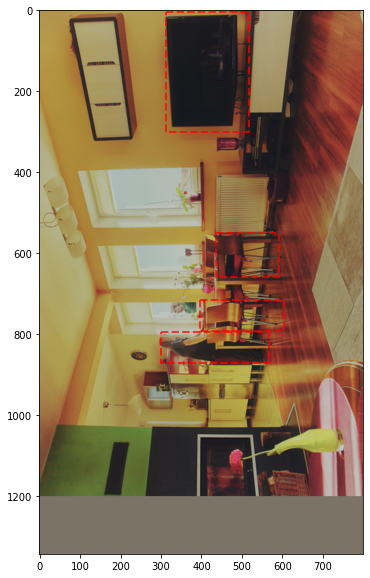

In [200]:
build_image(images.tensors[0], output[0], cfg)

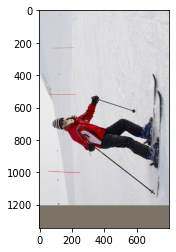

In [185]:
plt.imshow(image)

In [186]:
image

array([[[0.7961635 , 0.80787843, 0.8352161 ],
        [0.7961635 , 0.80787843, 0.8352161 ],
        [0.7961635 , 0.80787843, 0.8352161 ],
        ...,
        [0.8589086 , 0.8588588 , 0.8705102 ],
        [0.854987  , 0.8510157 , 0.8705102 ],
        [0.85106546, 0.8470941 , 0.8705102 ]],

       [[0.7961635 , 0.80787843, 0.8352161 ],
        [0.7961635 , 0.80787843, 0.8352161 ],
        [0.7961635 , 0.80787843, 0.8352161 ],
        ...,
        [0.8589086 , 0.8588588 , 0.8705102 ],
        [0.85106546, 0.8470941 , 0.86658865],
        [0.8471439 , 0.84317255, 0.86658865]],

       [[0.7961635 , 0.80787843, 0.8352161 ],
        [0.7961635 , 0.80787843, 0.8352161 ],
        [0.80008507, 0.8118    , 0.8391377 ],
        ...,
        [0.854987  , 0.85493726, 0.8626671 ],
        [0.8432223 , 0.84317255, 0.8587455 ],
        [0.83930075, 0.8353294 , 0.85482395]],

       ...,

       [[0.48145765, 0.45469216, 0.40384355],
        [0.48145765, 0.45469216, 0.40384355],
        [0.48145765, 0